# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf

from math import sqrt
from sklearn.metrics import mean_squared_error

from pylab import rcParams
rcParams['figure.figsize'] = 12,7

from pmdarima.arima import ARIMA
from pyramid.arima import auto_arima
import numpy as np
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

/Users/markbrennan/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/markbrennan/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
all_data = pd.read_csv('zillow_data.csv')

In [58]:
all_data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
def melt_data(df):
    """melt_data(df):
    Helper function helpfully provided
    for our work!
    
    Params:
        df:  dataframe to "melt" - convert wide format to long format
    Returns:
        Groupby object aggregated by mean values of sales indexed by time!
    """ 
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [6]:
def transform(ts, name):
    """transform(ts, name):
    Transform a time series (dataframe)
    using log, logmean, and sqrt and
    plot our transformations, using name of
    dataframe for plot.
    
    Params:
        ts:  dataframe to transform and plot
        name: name of dataframe (e.g., "New York")
    """
    ts_log = np.log(ts)
    ts_logmean = np.log(ts).rolling(window=7).mean()
    ts_sqrt= np.sqrt(ts)
        
    fig = plt.figure(figsize=(12,6))
    plt.xlabel(f'{name} - month: no transform', fontsize=14)
    plt.ylabel("monthly sales", fontsize=14)
    plt.plot(ts,  color='blue');
    plt.show()
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(ts_log, color='red');
    plt.xlabel(f'{name} - month: log', fontsize=14)
    plt.ylabel("monthly sales", fontsize=14)        
    plt.show()
    
    fig = plt.figure(figsize=(12,6))
    plt.xlabel(f'{name} - month: sqrt', fontsize=14)
    plt.ylabel("monthly sales", fontsize=14)        
    plt.plot(ts_sqrt, color='yellow');
    plt.show()
    
    fig = plt.figure(figsize=(12,6))
    plt.xlabel(f'{name} - month: log mean', fontsize=14)
    plt.ylabel("monthly sales", fontsize=14)        
    plt.plot(ts_logmean, color='green');
    plt.show()

In [7]:
def plot_ewm_diff(ts, name):
    """plot_ewm_diff(ts, name):
    Helper function takes log
    of series, then subtracts the exponentially
    weighted moving average, and finally
    differences the new series, as well as 
    drop nan values.  Finally, it 
    invokes the stationarity_check function.
    
    Params:
        ts: dataframe we are transforming
        name: name to use on plots (e.g., "New York")
    """
    # get log diff ewm first
    ts_log = np.log(ts)
    exp_rolmean = np.log(ts).ewm(halflife = 4).mean()
    log_diff_ewm = ts_log - exp_rolmean
    
    # difference it
    diff = log_diff_ewm.diff(periods=1)
    diff.dropna(inplace=True)
    
    # check and plot
    stationarity_check(diff, name)    

In [8]:
def stationarity_check(TS, name):
    """stationarity_check(TS, name):
    Helper function from Learn.co lab!
    It checks for the stationarity of a given timeseries using 
    rolling stats and DF test.
    
    Params:
        ts: dataframe we are transforming
        name: name to use on plots (e.g., "New York")
    """    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['value']) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{name} - Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print (f'Results of Dickey-Fuller Test - {name}:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [171]:
def create_and_plot_train_valid(df, name):
    """create_and_plot_train_valid(df, name):
    Borrowed code!  Use the pm.auto_arima method to fit our model.
    
    First divide our data into a training sample (80%), and
    a validation sample (20%).  Fit the model on the training
    sample.  Create a prediction sample of equal size to the
    validation sample.  Then plot.
    
    Params:
        df:  dataframe to train/validate, and fit
        name: name of our dataframe for plotting (e.g., "New York")
    """
    
    #divide into train and validation set
    train = df[:int(0.8*(len(df)))]
    valid = df[int(0.8*(len(df))):]
    
    stepwise_fit = pm.auto_arima(train, start_p=1, start_q=1, max_p=8, max_q=1, m=12,
                                 start_P=0, seasonal=False, d=1, D=1, trace=False,
                                 error_action='ignore',  # don't want to know if an order does not work
                                 suppress_warnings=True,  # don't want convergence warnings
                                 stepwise=True)  # set to stepwise

    #stepwise_fit.summary()

    stepwise_fit.fit(train['value'])

    forecast = stepwise_fit.predict(n_periods=len(valid))
    
    print('\n')
    print('*' * 75)
    print(f'********** Summary for forecast model for: {name.upper()}')
    print('*' * 75)    
    print(stepwise_fit.summary())
    
    # forecast = model.predict(n_periods=len(valid))

    forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])
    
    # print out our forecast accuracy stats here:
    forecast_dict_vals = forecast_accuracy(forecast, valid)
    print('\nError Statistics for', name)
    print(pd.DataFrame.from_dict(forecast_dict_vals, orient='index', columns=['Value']))
    
    fig = plt.figure(figsize=(12,6))
    
    rmse = round(sqrt(mean_squared_error(valid,forecast)), 2)
    
    font = {'family' : 'sans-serif',
            'weight' : 'bold',
            'size'   : 12}

    matplotlib.rc('font', **font)

    #plot the predictions for validation set
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Sales', fontsize=14)        
    plt.title(f'{name}')

    
    plt.plot(train, label='Train')
    plt.plot(valid, label='Valid')
    plt.plot(forecast, label='Prediction')
    
    # Plot residuals
    residuals = pd.DataFrame(stepwise_fit.resid())

    residuals.plot(label='Residuals')
    plt.title('Residuals')    
    
    residuals.plot(kind='kde')
    plt.title('Residuals')    

#    plt.plot(residuals)
#    plt.title('Residuals')
    plt.grid()
    
    plt.legend(loc='best')   
    
    plt.show()

In [155]:
def forecast_accuracy(forecast, actual):
    """forecast_accuracy(forecast, actual):
    Derive some statistics comparing our validation
    data set against our predicted time series values.
    Code borrowed from Analytics Vidhya.
    Params:
        forecast: data frame consisting of our predicted values
        actual:  data frame consisting of our validation data set values
    """
    
    # we need to normalize series data, which is named differently
    # in each dataframe.
    forecast = forecast.Prediction
    actual = actual.value
    # get the statistics using numpy functions
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack((forecast, actual)))
    maxs = np.amax(np.hstack((forecast, actual)))
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    # we are not using ACF here
    #    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [10]:
def series_plot(df, name, color):
    """series_plot(df, name, color):
    Plot our "original" time series data by
    name and color.
    
    Params:
        df: dataframe (time series) to plot
        name: name of series (e.g., 'New York')
        color: color to use for plot
    """
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color=color, label='Series before transform')
    plt.xlabel("month", fontsize=14)
    plt.ylabel("monthly sales", fontsize=14)
    plt.legend(loc='best')
    plt.title(f'{name}')    
    plt.show()

In [11]:
##
## MAIN CODE
##

#
# CONSTANTS (define our metro areas of interest)
METRO_AREAS = ['Chicago', 'New York', 'Los Angeles-Long Beach-Anaheim', 'Washington', 'Boston']

# CONSTANTS (define colors for for plotting)
COLORS = ['blue', 'red', 'green', 'yellow', 'orange']
#
# Create array of dataframes for our metro areas of interest
#
metro_df_dicts = []

# Create an array of dicts of dataframes and associated metro names
for index, metro_name in enumerate(METRO_AREAS):
    df = all_data[all_data['Metro'] == metro_name]
    melt_df = melt_data(df)
    color = COLORS[index]
    metro_df_dicts.append(dict(name=metro_name, df=melt_df, color=color))

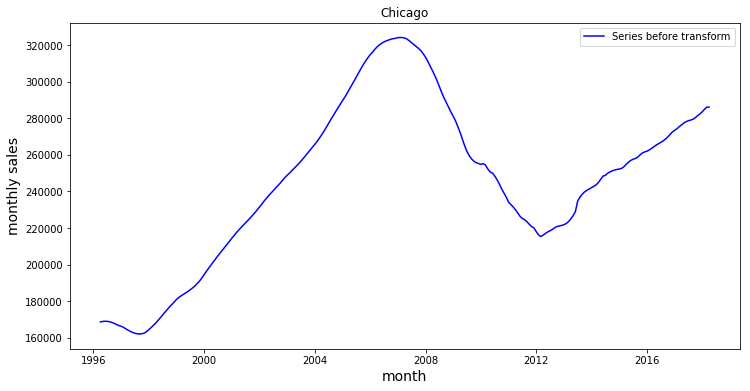

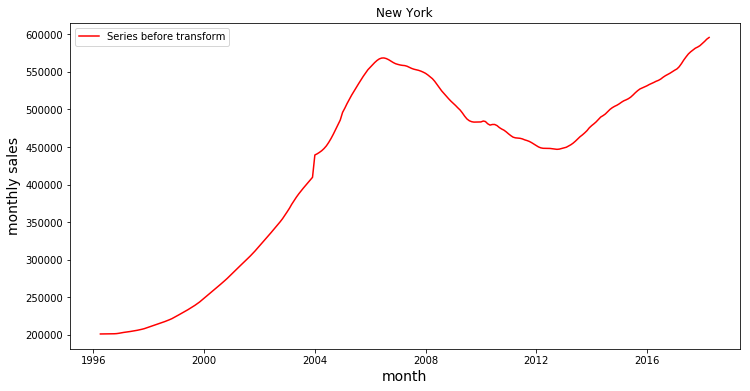

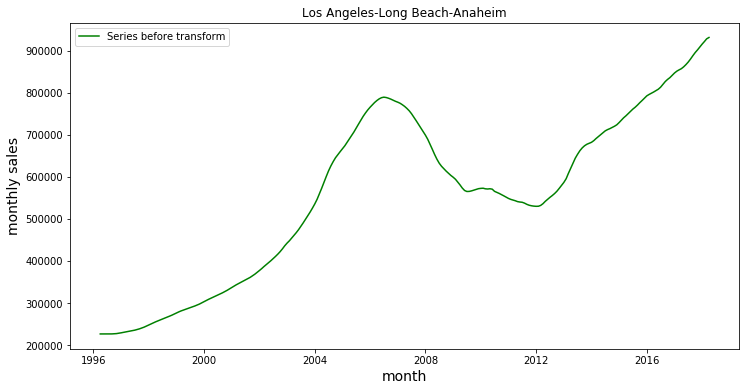

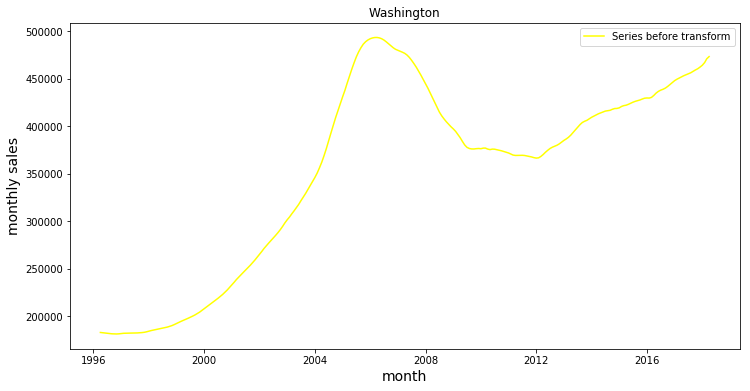

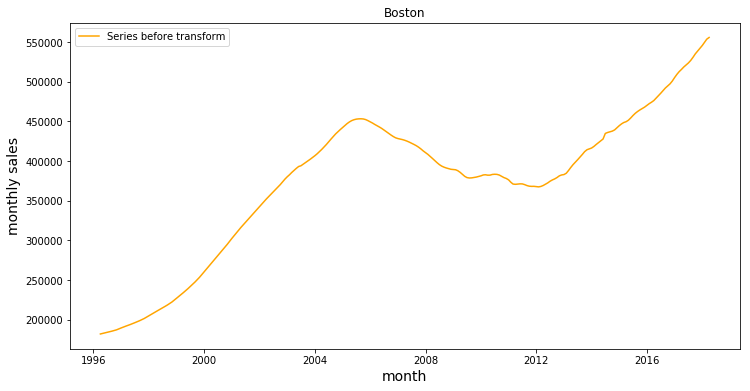

In [12]:
#
# Plot our initial, non-transformed time series
#
for metro in metro_df_dicts:
    series_plot(metro['df'], metro['name'], metro['color'])

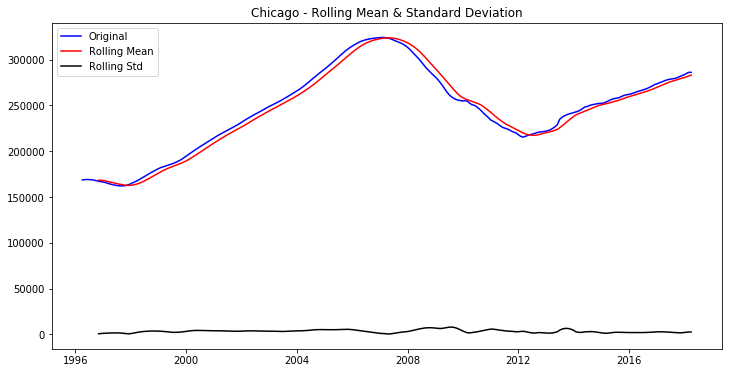

Results of Dickey-Fuller Test - Chicago:
Test Statistic                  -3.339468
p-value                          0.013204
#Lags Used                       9.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


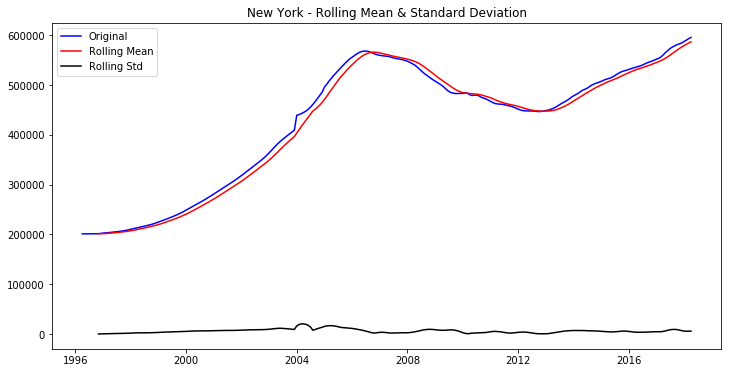

Results of Dickey-Fuller Test - New York:
Test Statistic                  -1.787339
p-value                          0.386765
#Lags Used                       7.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


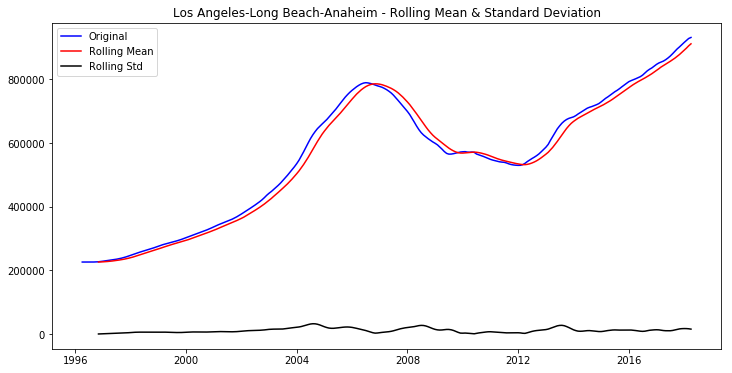

Results of Dickey-Fuller Test - Los Angeles-Long Beach-Anaheim:
Test Statistic                  -1.916641
p-value                          0.324274
#Lags Used                       8.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


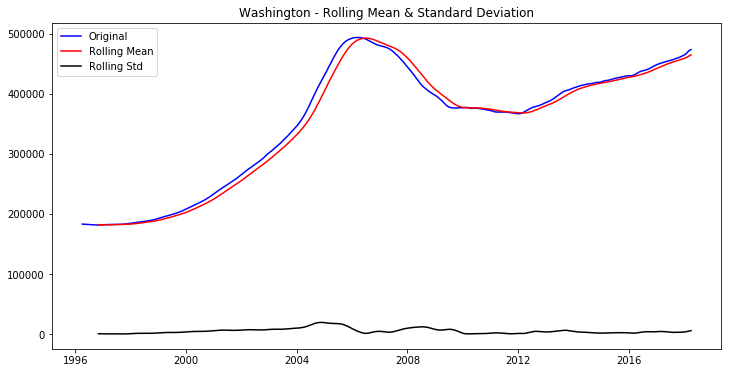

Results of Dickey-Fuller Test - Washington:
Test Statistic                  -1.927931
p-value                          0.319038
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


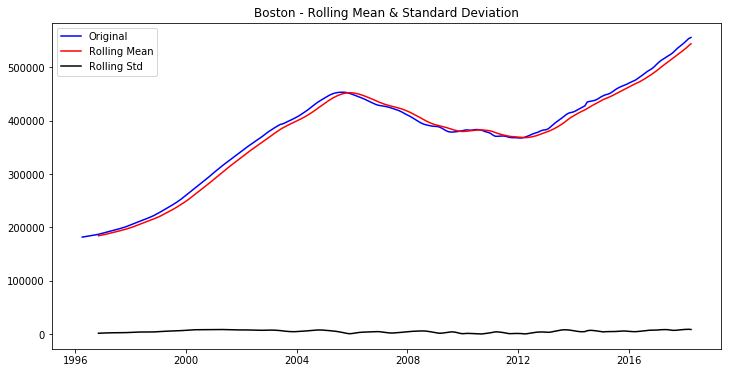

Results of Dickey-Fuller Test - Boston:
Test Statistic                  -1.394731
p-value                          0.584800
#Lags Used                       4.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [13]:
#
# Check stationarity of each time series
#
for metro in metro_df_dicts:
    stationarity_check(metro['df'], metro['name'])

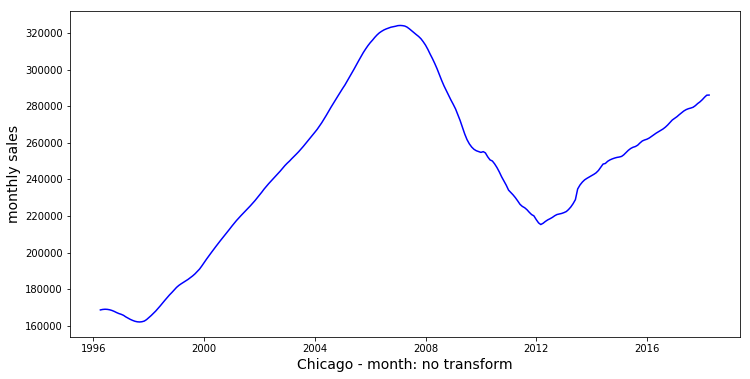

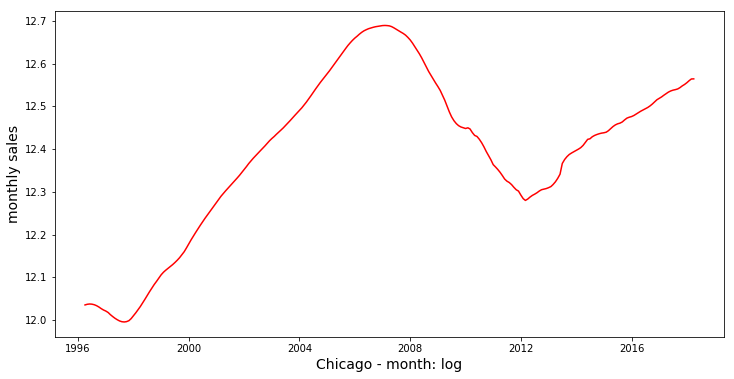

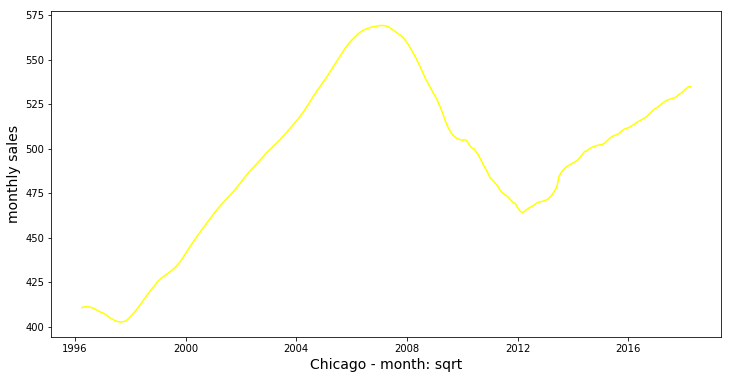

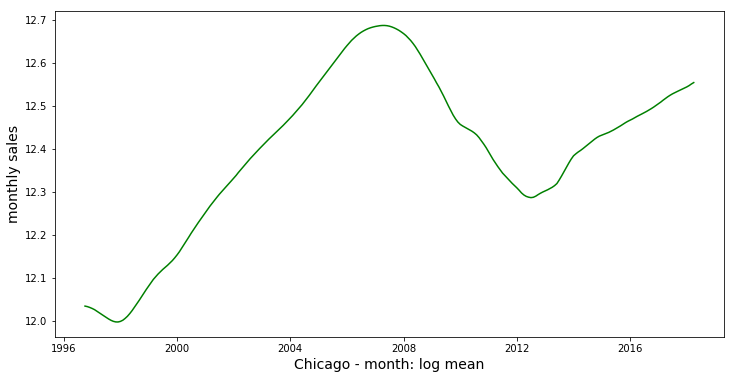

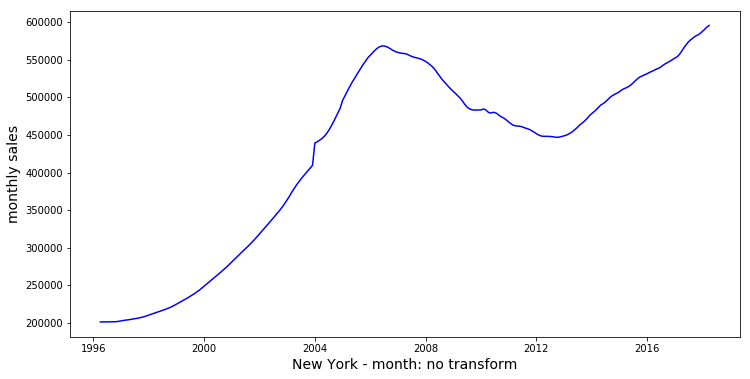

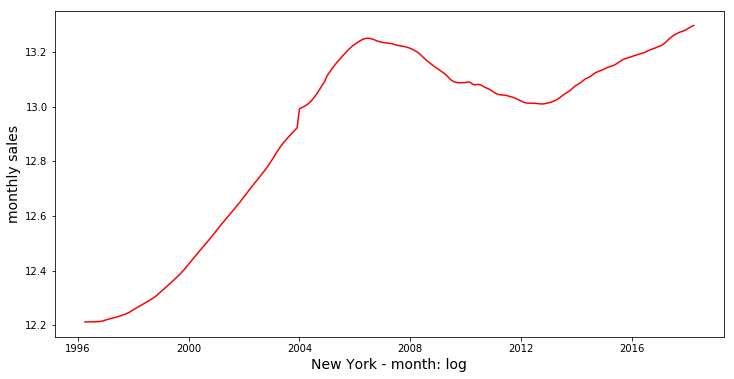

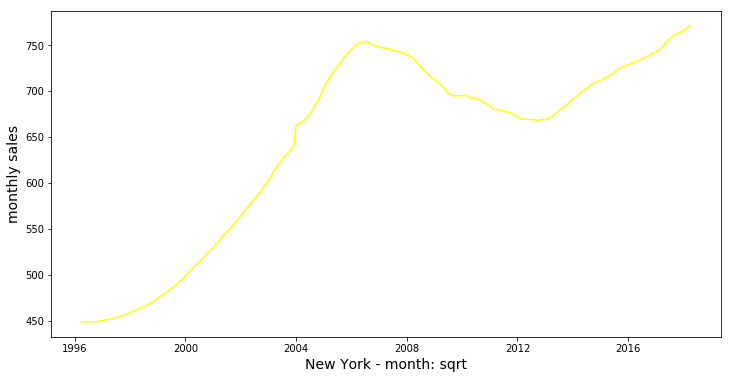

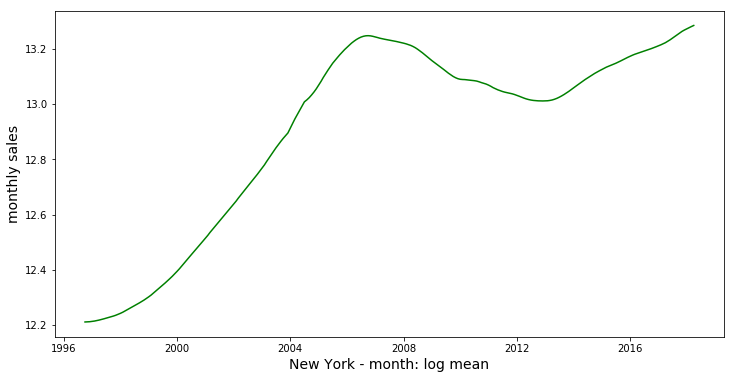

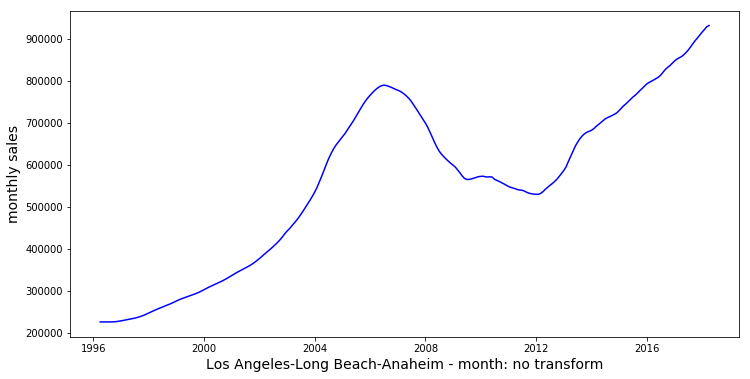

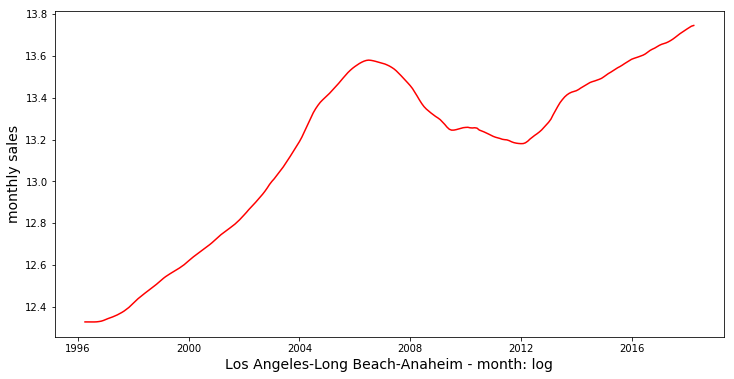

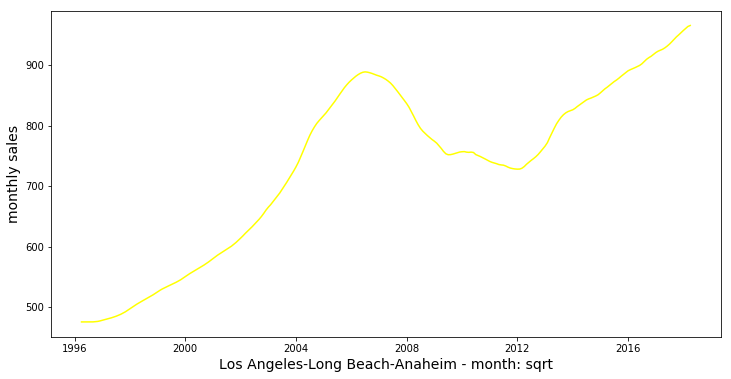

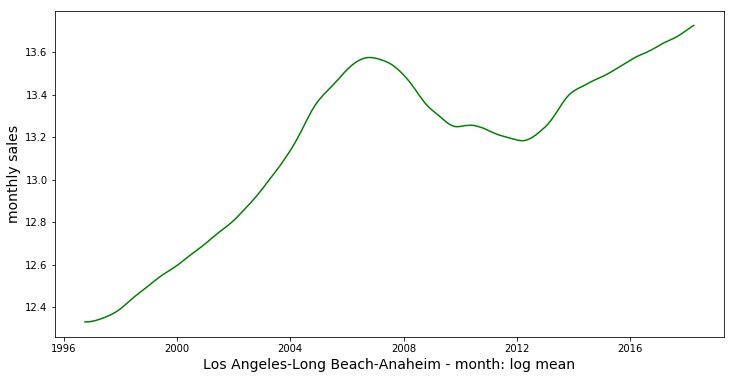

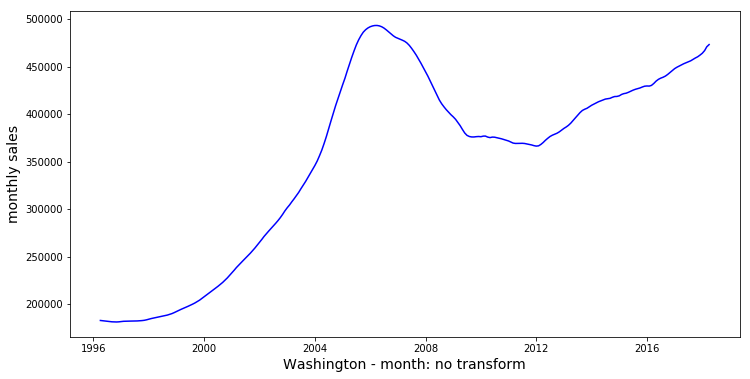

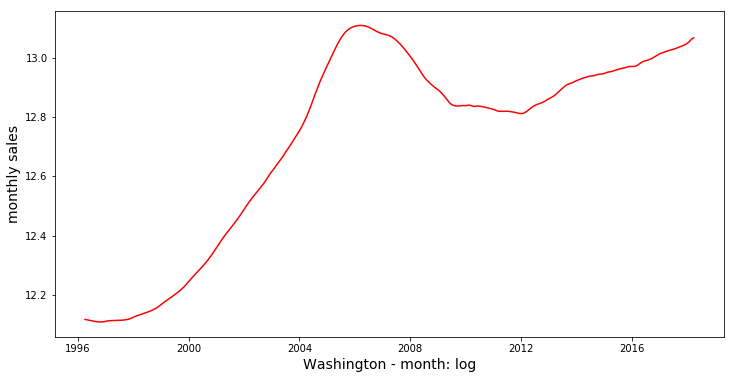

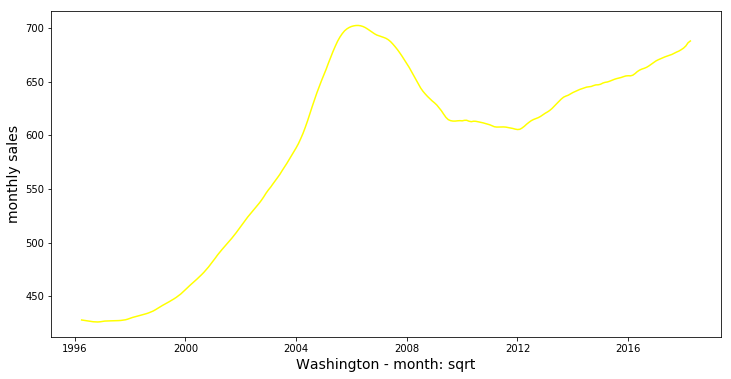

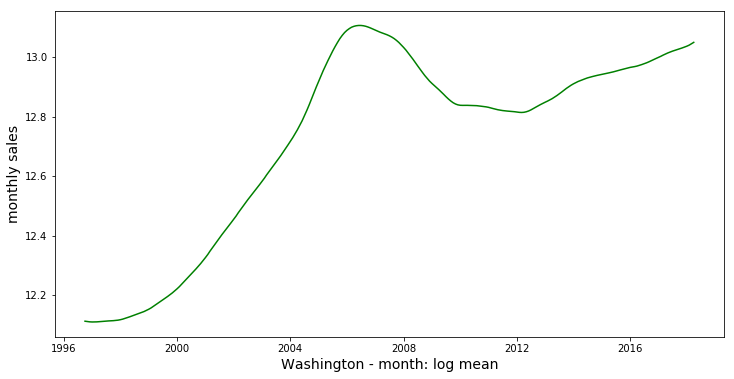

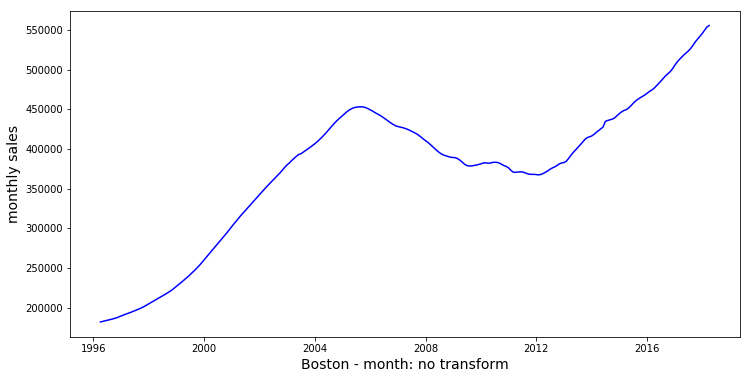

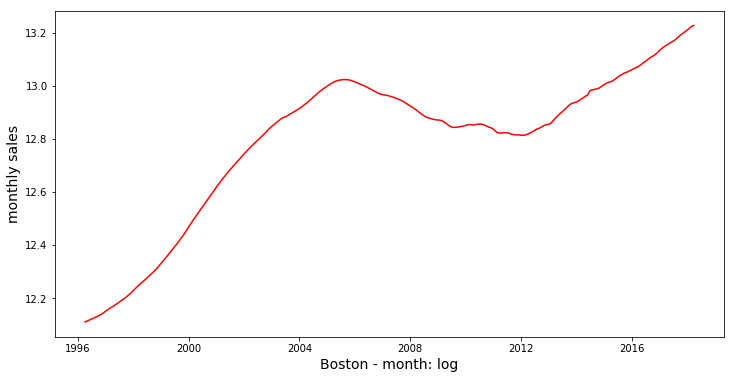

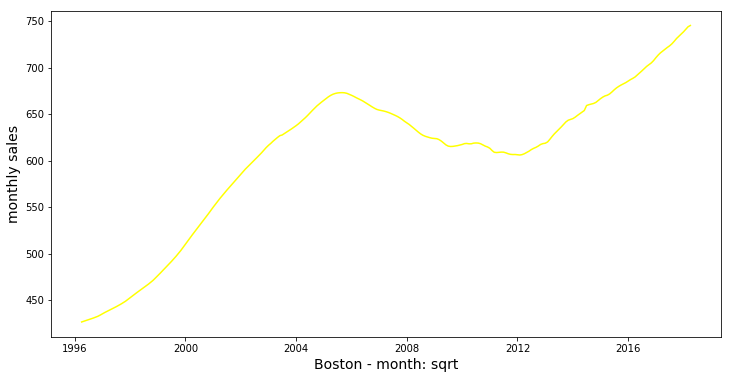

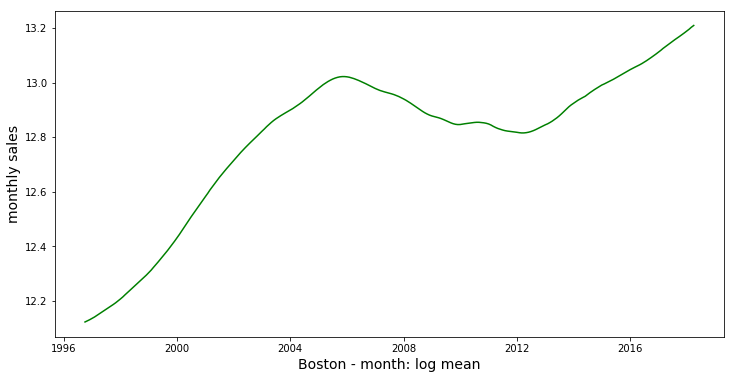

In [14]:
#
# Try some transformations on our time series:
# log, log mean, sqrt
#
for metro in metro_df_dicts:
    transform(metro['df'], metro['name'])

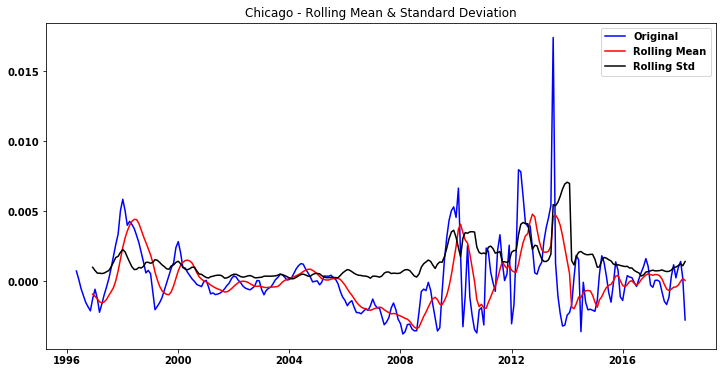

Results of Dickey-Fuller Test - Chicago:
Test Statistic                -6.277273e+00
p-value                        3.872984e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.630000e+02
Critical Value (1%)           -3.455461e+00
Critical Value (5%)           -2.872593e+00
Critical Value (10%)          -2.572660e+00
dtype: float64


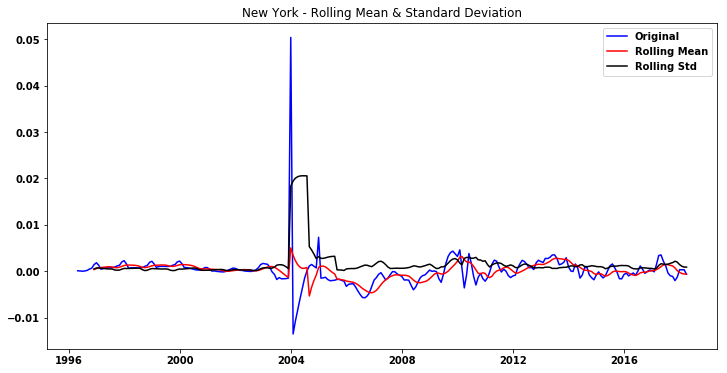

Results of Dickey-Fuller Test - New York:
Test Statistic                -1.523769e+01
p-value                        5.214996e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.630000e+02
Critical Value (1%)           -3.455461e+00
Critical Value (5%)           -2.872593e+00
Critical Value (10%)          -2.572660e+00
dtype: float64


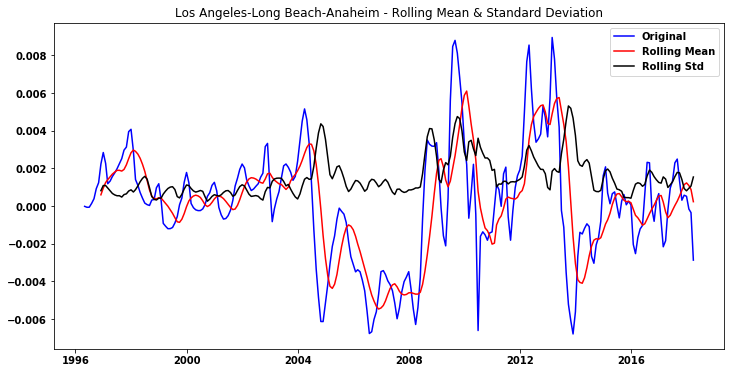

Results of Dickey-Fuller Test - Los Angeles-Long Beach-Anaheim:
Test Statistic                  -2.984607
p-value                          0.036357
#Lags Used                       7.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


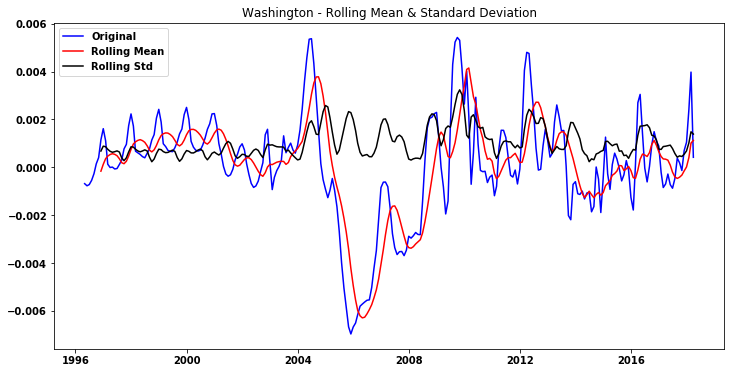

Results of Dickey-Fuller Test - Washington:
Test Statistic                  -3.109897
p-value                          0.025829
#Lags Used                      10.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


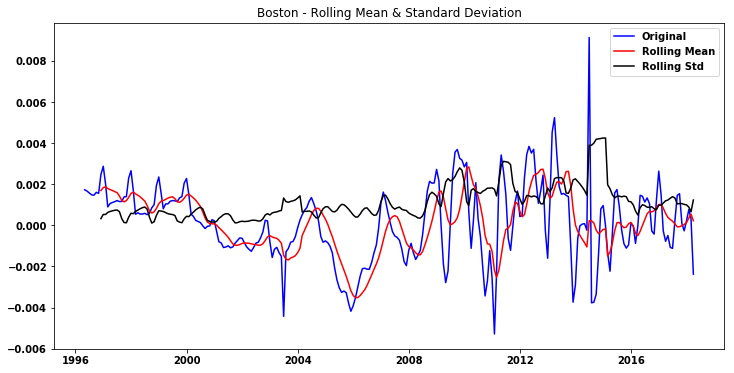

Results of Dickey-Fuller Test - Boston:
Test Statistic                  -4.755423
p-value                          0.000066
#Lags Used                       3.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


In [136]:
#
# Take the exponentially weighted mean difference
# (It turns out to be the best transformation)
#
for metro in metro_df_dicts:
    plot_ewm_diff(metro['df'], metro['name'])

In [15]:
#
# ACF and PACF
#

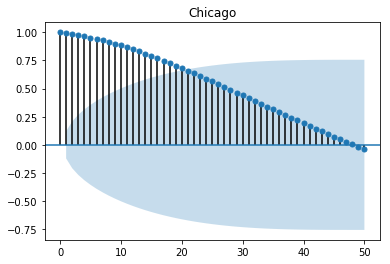

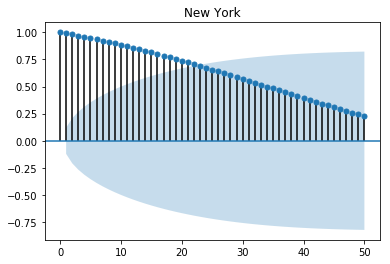

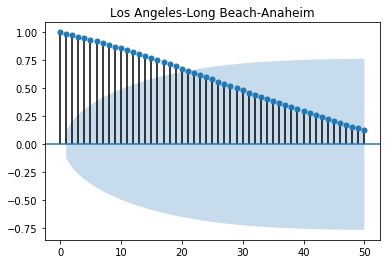

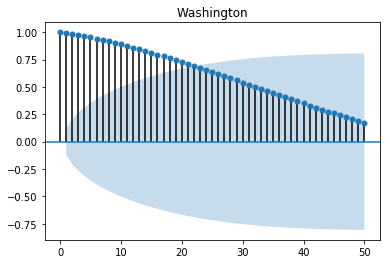

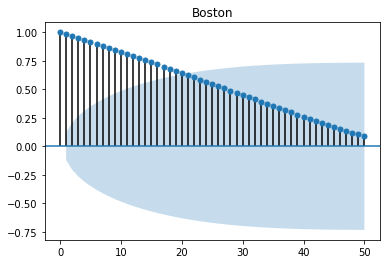

In [16]:
#plot autocorrelation for each lag (alpha is confidence interval)
for metro in metro_df_dicts:
    plot_acf(metro['df'][:-1], title=metro['name'], lags=50, alpha=.05)

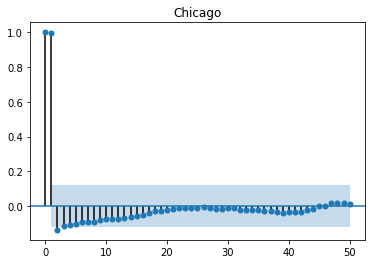

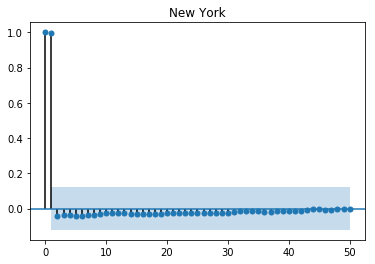

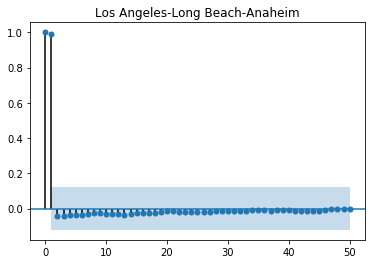

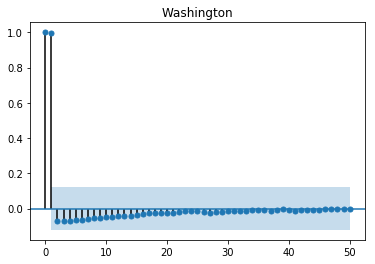

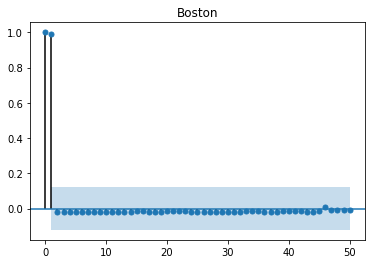

In [17]:
#plot partial autocorrelation for each lag (alpha is confidence interval)
for metro in metro_df_dicts:
    plot_pacf(metro['df'][:-1], title=metro['name'], lags=50, alpha=.05)

In [140]:
#
# Fit our model for each region!
# And print results for each model
#
fit_array = []

# Iterate over our metro areas and fit a model for each area
for metro in metro_df_dicts:
    model = pm.auto_arima(metro['df'], start_p=1, start_q=1, max_p=8, max_q=1, m=12,
                             start_P=0, seasonal=False, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True) # set to stepwise

    fit_array.append(dict(model=model, name=metro['name']))

# iterate over our array of models to print summary
# statistics for each metro area's model
for item in fit_array:
    print('\n')    
    name = item['name']
    model = item['model']
    
    print('\n')
    print('*** Model for ', name)
    print(model.summary())
    print('\n')    


Fit ARIMA: order=(1, 1, 1); AIC=3992.202, BIC=4006.506, Fit time=0.184 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4601.473, BIC=4608.624, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=3990.733, BIC=4001.460, Fit time=0.038 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4346.863, BIC=4357.591, Fit time=0.131 seconds
Fit ARIMA: order=(2, 1, 0); AIC=3992.304, BIC=4006.608, Fit time=0.124 seconds
Fit ARIMA: order=(2, 1, 1); AIC=3992.479, BIC=4010.358, Fit time=0.377 seconds
Total fit time: 0.859 seconds
Fit ARIMA: order=(1, 1, 1); AIC=4758.169, BIC=4772.473, Fit time=0.656 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4974.132, BIC=4981.284, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4826.364, BIC=4837.091, Fit time=0.022 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4895.037, BIC=4905.765, Fit time=0.018 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4760.146, BIC=4778.025, Fit time=0.427 seconds
Total fit time: 1.128 seconds
Fit ARIMA: order=(1, 1, 1); AIC=4278.636, BIC=4292.940, Fit time=0.316 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  264
Model:                 ARIMA(8, 1, 1)   Log Likelihood               -1882.246
Method:                       css-mle   S.D. of innovations            298.543
Date:                Thu, 05 Sep 2019   AIC                           3786.492
Time:                        18:07:45   BIC                           3825.827
Sample:                             1   HQIC                          3802.298
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        900.3255   1040.773      0.865      0.388   -1139.553    2940.204
ar.L1.D.y      1.3561      0.133     10.211      0.000       1.096       1.616
ar.L2.D.y     -0.6407      0.243     -2.634      0.0



***************************************************************************
********** Summary for forecast model for: CHICAGO
***************************************************************************
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  211
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1602.334
Method:                       css-mle   S.D. of innovations            477.946
Date:                Fri, 06 Sep 2019   AIC                           3210.668
Time:                        10:43:32   BIC                           3220.724
Sample:                             1   HQIC                          3214.733
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

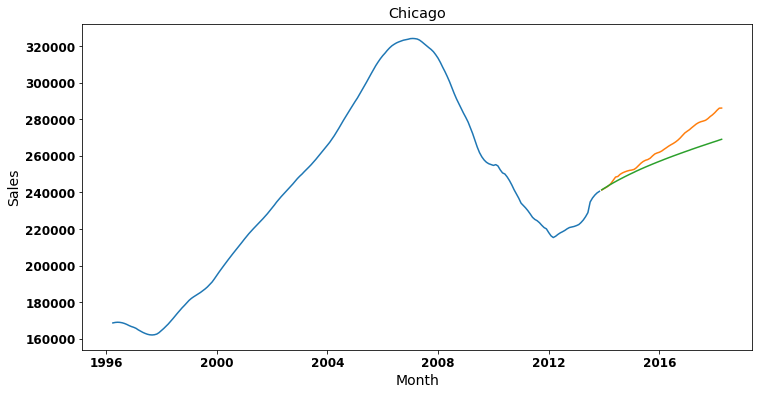

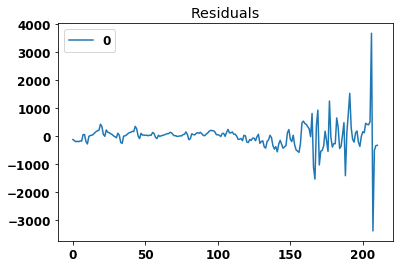

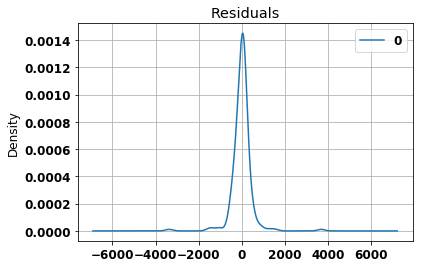



***************************************************************************
********** Summary for forecast model for: NEW YORK
***************************************************************************
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  211
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1918.940
Method:                       css-mle   S.D. of innovations           2148.562
Date:                Fri, 06 Sep 2019   AIC                           3845.881
Time:                        10:43:35   BIC                           3859.288
Sample:                             1   HQIC                          3851.300
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons

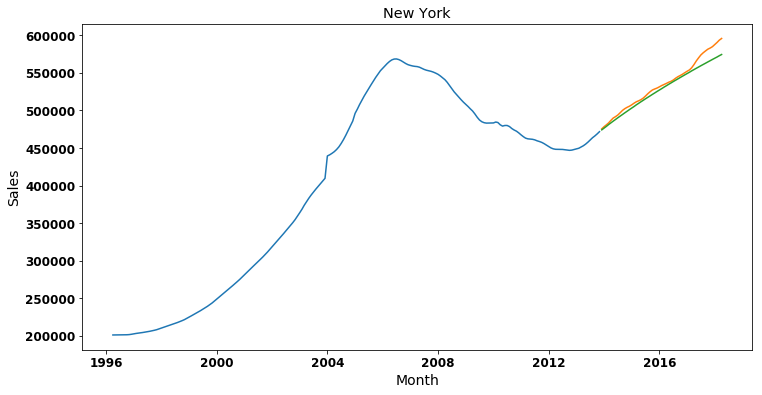

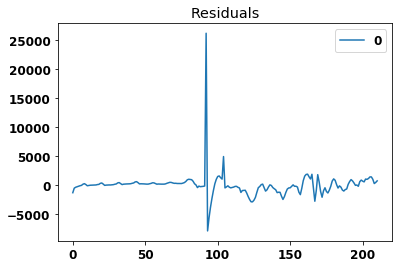

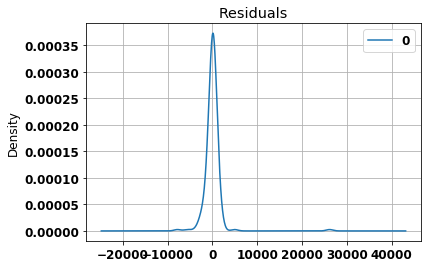



***************************************************************************
********** Summary for forecast model for: LOS ANGELES-LONG BEACH-ANAHEIM
***************************************************************************
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  211
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1698.921
Method:                       css-mle   S.D. of innovations            752.136
Date:                Fri, 06 Sep 2019   AIC                           3405.842
Time:                        10:43:37   BIC                           3419.250
Sample:                             1   HQIC                          3411.262
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

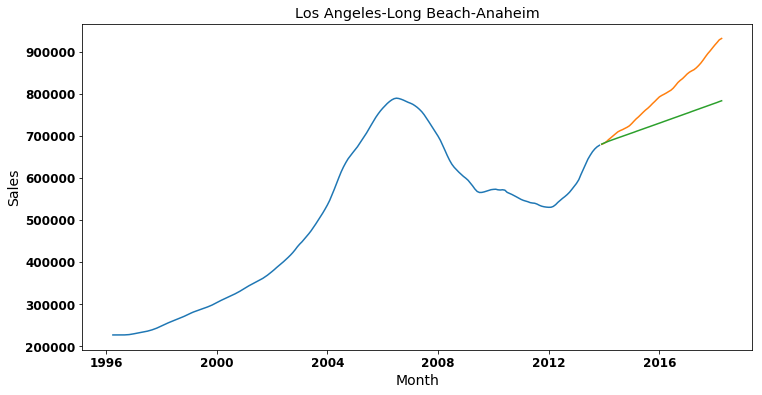

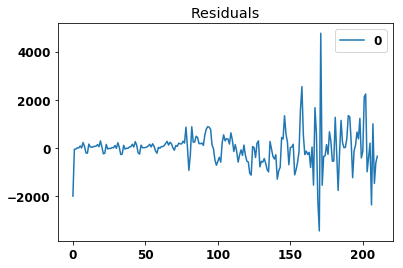

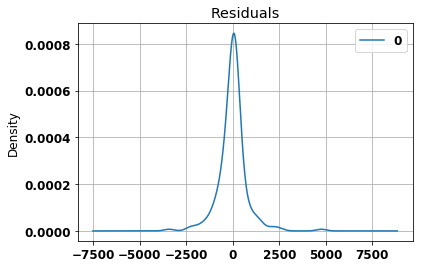



***************************************************************************
********** Summary for forecast model for: WASHINGTON
***************************************************************************
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  211
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1487.644
Method:                       css-mle   S.D. of innovations            275.544
Date:                Fri, 06 Sep 2019   AIC                           2985.288
Time:                        10:43:41   BIC                           3002.047
Sample:                             1   HQIC                          2992.062
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

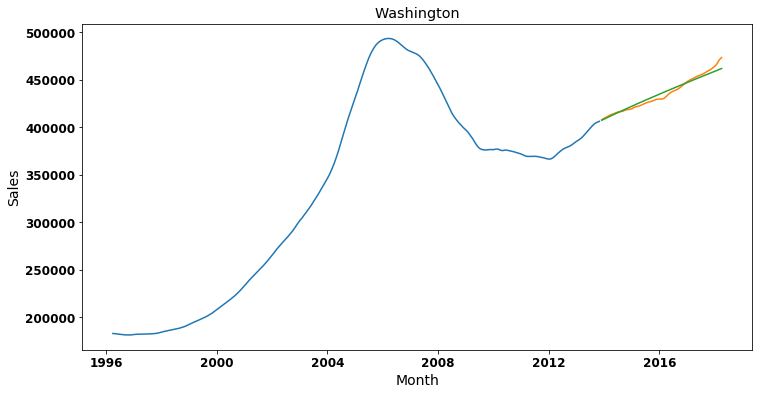

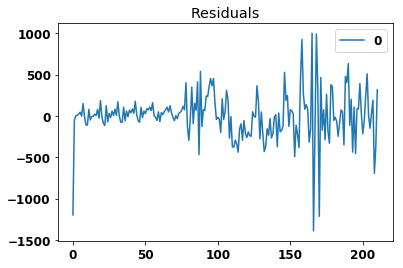

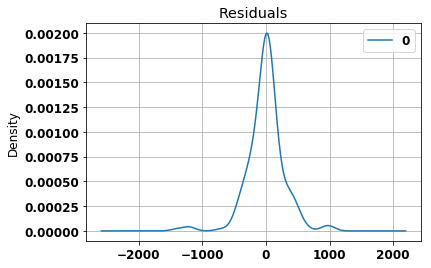



***************************************************************************
********** Summary for forecast model for: BOSTON
***************************************************************************
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  211
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1547.011
Method:                       css-mle   S.D. of innovations            366.669
Date:                Fri, 06 Sep 2019   AIC                           3102.022
Time:                        10:43:44   BIC                           3115.429
Sample:                             1   HQIC                          3107.441
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const 

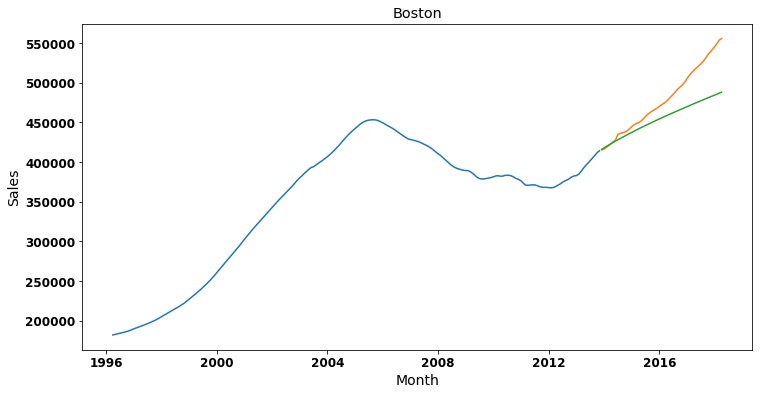

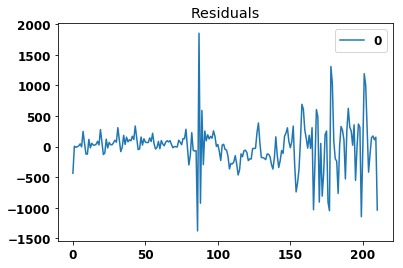

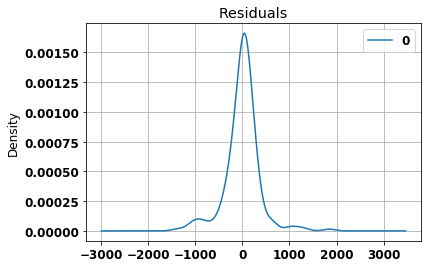

In [172]:
#
# Do the main work to get training and validation data,
# then fit the model on the training data.  Then predict
# and compare predicted results with our validation set, 
# plotting al of it
#
for metro in metro_df_dicts:
    create_and_plot_train_valid(metro['df'], metro['name'])